In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [3]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT', 'CRVUSDT', 'FILUSDT', 'ONEUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['price'] = prices[asset]['price'].apply(lambda x: math.log(x))



In [4]:
prices['BTCUSDT']

,date,price
0,2020-01-01 05:00:00,8.883759
1,2020-01-01 06:00:00,8.884278
2,2020-01-01 07:00:00,8.880936
3,2020-01-01 08:00:00,8.878219
4,2020-01-01 09:00:00,8.879439
...,...,...
956,2022-03-01 01:00:00,10.673945
957,2022-03-01 02:00:00,10.667885
958,2022-03-01 03:00:00,10.665461
959,2022-03-01 04:00:00,10.670401


## Rolling Cointegration Engle-Granger

In [5]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue, result.params[0]


In [6]:
##
# asset_A: string,
# asset_B: string,
# prices: object containing all imported data
# lookback_window: int that represents the max we are willing to lookback
# rolling_lookback: int that represents the length of the rolling window
def rolling_coint_consecutive_candles(asset_A, asset_B, prices, lookback_window, rolling_lookback):
    
    data_A = prices[asset_A][(len(prices[asset_A])-lookback_window):]
    data_B = prices[asset_B][(len(prices[asset_B])-lookback_window):]

    # make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_pvalues = pd.DataFrame({'date':[], 'pvalue': [], 'beta': []})
    cointegrated = False
    saveDate = True
    consecutive_candles_cointegrated = 0
    start_date = ''
    beta = 0

    _consecutive_candles_df = pd.DataFrame({'start_date': [], 'nbr_of_candles': [], 'beta': []})

    for i in range(0, len(data_A)):
        if i+rolling_lookback <= len(data_A):
            data_1 = list(data_A['price'].iloc[i:i+rolling_lookback])
            data_2 = list(data_B['price'].iloc[i:i+rolling_lookback])
            pvalue, beta_data_2 = engle_granger_coint(data_1, data_2)
            rolling_pvalues = pd.concat([rolling_pvalues, pd.DataFrame({'date': [data_A['date'].iloc[i]], 'pvalue': [pvalue], 'beta': [beta_data_2]})])
            if pvalue <= 0.05 and not cointegrated:
                cointegrated = True
            elif pvalue <= 0.05 and cointegrated:
                consecutive_candles_cointegrated += 1
                if saveDate and consecutive_candles_cointegrated > 3:
                    start_date = data_A['date'].iloc[i-3]
                    beta = float(rolling_pvalues['beta'].tail(1))
                    saveDate = False
            else:
                if consecutive_candles_cointegrated and not saveDate > 0:
                    _consecutive_candles_df = pd.concat([_consecutive_candles_df, pd.DataFrame({'start_date': [start_date], 'nbr_of_candles': [consecutive_candles_cointegrated], 'beta': [beta]})])

                # reset variables
                cointegrated = False
                consecutive_candles_cointegrated = 0
                saveDate = True
                start_date = ''
                beta = 0
    
    return _consecutive_candles_df, rolling_pvalues

## Example of rolling cointegration for a specific pair

In [9]:
asset_A = 'SANDUSDT'
asset_B = 'MANAUSDT'

# nbr of datapoints
max_lookback = 2160

# nbr of candles to use in the cointegration calculation
rolling_lookback = 24*10
consecutive_candles_df, rolling_coint_stats = rolling_coint_consecutive_candles(asset_A, asset_B, prices, max_lookback, rolling_lookback)

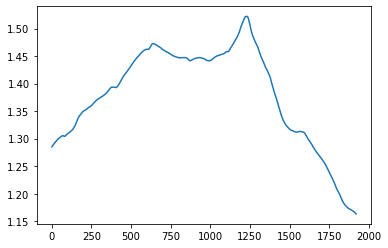

In [10]:
plt.plot(list(rolling_coint_stats['beta']))

## Get statistics of results

In [11]:
# Calculate max, min, mean and median of the consecutive periods cointegrated for each pair
print('max: {}, min: {}, mean: {}, median: {}, times cointegrated: {}'.format(consecutive_candles_df['nbr_of_candles'].max(), consecutive_candles_df['nbr_of_candles'].min(), consecutive_candles_df['nbr_of_candles'].mean(), consecutive_candles_df['nbr_of_candles'].median(), len(consecutive_candles_df)))
consecutive_candles_df

max: 28.0, min: 4.0, mean: 12.181818181818182, median: 10.0, times cointegrated: 11


,start_date,nbr_of_candles,beta
0,2021-12-02 06:00:00,11.0,1.295380
0,2021-12-02 20:00:00,4.0,1.299629
0,2021-12-12 19:00:00,5.0,1.369235
0,2021-12-27 10:00:00,10.0,1.471364
0,2021-12-28 07:00:00,6.0,1.471130
0,2022-01-02 10:00:00,23.0,1.449159
0,2022-01-04 05:00:00,8.0,1.446873
0,2022-01-05 02:00:00,21.0,1.447228
0,2022-01-07 09:00:00,4.0,1.444512
0,2022-01-20 13:00:00,14.0,1.514826


## Calculate consecutive candles cointegrated for all pairs

In [7]:
def consecutive_candles_coint_pairs(selected_assets, max_lookback, rolling_lookback):
    consecutive_candles = {}
    
    # pairs loop
    counter = 0
    # no duplicates and no same asset pair
    total_pairs = int((len(selected_assets) * len(selected_assets) - len(selected_assets)) / 2)
    for asset_a in selected_assets:
        for asset_b in selected_assets:
            if asset_a != asset_b and '{}/{}'.format(asset_b, asset_a) not in consecutive_candles.keys():
                counter += 1
                print("Calculating pair {} of {}".format(counter, total_pairs))
                consecutive_candles['{}/{}'.format(asset_a, asset_b)] = rolling_coint_consecutive_candles(asset_a, asset_b, prices, max_lookback, rolling_lookback)

    print('Done')
    return consecutive_candles
        

In [70]:
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT']
assets_old = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT', 'ADAUSDT']
assets_L1 = ['ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'AVAXUSDT', 'FTMUSDT', 'ATOMUSDT']
assets_metaverse = ['GALAUSDT', 'SANDUSDT', 'MANAUSDT', 'AXSUSDT']

# params
max_lookback = 2160*4
rolling_lookback = 24*10

# run
all_df = consecutive_candles_coint_pairs(assets, max_lookback, rolling_lookback)
#metaverse_df = consecutive_candles_coint_pairs(assets_metaverse, max_lookback, rolling_lookback)
#L1_df = consecutive_candles_coint_pairs(assets_L1, max_lookback, rolling_lookback)
#legacy_df = consecutive_candles_coint_pairs(assets_old, max_lookback, rolling_lookback)


Calculating pair 1 of 276
Calculating pair 2 of 276
Calculating pair 3 of 276
Calculating pair 4 of 276
Calculating pair 5 of 276
Calculating pair 6 of 276
Calculating pair 7 of 276
Calculating pair 8 of 276
Calculating pair 9 of 276
Calculating pair 10 of 276
Calculating pair 11 of 276
Calculating pair 12 of 276
Calculating pair 13 of 276
Calculating pair 14 of 276
Calculating pair 15 of 276
Calculating pair 16 of 276
Calculating pair 17 of 276
Calculating pair 18 of 276
Calculating pair 19 of 276
Calculating pair 20 of 276
Calculating pair 21 of 276
Calculating pair 22 of 276
Calculating pair 23 of 276
Calculating pair 24 of 276
Calculating pair 25 of 276
Calculating pair 26 of 276
Calculating pair 27 of 276
Calculating pair 28 of 276
Calculating pair 29 of 276
Calculating pair 30 of 276
Calculating pair 31 of 276
Calculating pair 32 of 276
Calculating pair 33 of 276
Calculating pair 34 of 276
Calculating pair 35 of 276
Calculating pair 36 of 276
Calculating pair 37 of 276
Calculatin

## Get statistics from all pairs

In [71]:
df = pd.DataFrame({'pair': [], 'start_date_max': [], 'max': [], 'min': [], 'mean': [], 'median': [], 'times_cointegrated': [], 'beta': []})
pairs = {
    'legacy': df,
    'metaverse' : df,
    'L1': df,
    'all': df
}
"""
for pair in legacy_df:
    stats_df = pd.DataFrame({
        'pair': pair,
        'start_date_max': legacy_df[pair][legacy_df[pair]['nbr_of_candles'] == legacy_df[pair]['nbr_of_candles'].max()]['start_date'], 
        'max': legacy_df[pair]['nbr_of_candles'].max(), 
        'min': legacy_df[pair]['nbr_of_candles'].min(), 
        'mean': legacy_df[pair]['nbr_of_candles'].mean(), 
        'median': legacy_df[pair]['nbr_of_candles'].median(),
        'times_cointegrated': len(legacy_df[pair]),
        'beta': 1 #todo
    })
    
    pairs['legacy'] = pd.concat([pairs['legacy'], stats_df])
pairs['legacy'] = pairs['legacy'].set_index('pair')
    
for pair in metaverse_df:
    stats_df = pd.DataFrame({
        'pair': pair,
        'start_date_max': metaverse_df[pair][metaverse_df[pair]['nbr_of_candles'] == metaverse_df[pair]['nbr_of_candles'].max()]['start_date'], 
        'max': metaverse_df[pair]['nbr_of_candles'].max(), 
        'min': metaverse_df[pair]['nbr_of_candles'].min(), 
        'mean': metaverse_df[pair]['nbr_of_candles'].mean(), 
        'median': metaverse_df[pair]['nbr_of_candles'].median(),
        'times_cointegrated': len(metaverse_df[pair]),
        'beta': 1 #todo
    })
    
    pairs['metaverse'] = pd.concat([pairs['metaverse'], stats_df])
pairs['metaverse'] = pairs['metaverse'].set_index('pair')

for pair in L1_df:
    stats_df = pd.DataFrame({
        'pair': pair,
        'start_date_max': L1_df[pair][0][L1_df[pair][0]['nbr_of_candles'] == L1_df[pair][0]['nbr_of_candles'].max()]['start_date'], 
        'max': L1_df[pair][0]['nbr_of_candles'].max(), 
        'min': L1_df[pair][0]['nbr_of_candles'].min(), 
        'mean': L1_df[pair][0]['nbr_of_candles'].mean(), 
        'median': L1_df[pair][0]['nbr_of_candles'].median(),
        'times_cointegrated': len(L1_df[pair]),
        'beta': 1 #todo
    })
    pairs['L1'] = pd.concat([pairs['L1'], stats_df])
pairs['L1'] = pairs['L1'].set_index('pair')

"""
for pair in all_df:
    stats_df = pd.DataFrame({
        'pair': pair,
        'start_date_max': all_df[pair][0][all_df[pair][0]['nbr_of_candles'] == all_df[pair][0]['nbr_of_candles'].max()]['start_date'], 
        'max': all_df[pair][0]['nbr_of_candles'].max(), 
        'min': all_df[pair][0]['nbr_of_candles'].min(), 
        'mean': all_df[pair][0]['nbr_of_candles'].mean(), 
        'median': all_df[pair][0]['nbr_of_candles'].median(),
        'times_cointegrated': len(all_df[pair]),
        'beta': 1 #todo
    })
    
    pairs['all'] = pd.concat([pairs['all'], stats_df])
pairs['all'] = pairs['all'].set_index('pair')


In [72]:
pairs_coint

,BTCUSDT/ETHUSDT,BTCUSDT/LUNAUSDT,BTCUSDT/SOLUSDT,BTCUSDT/FTMUSDT,BTCUSDT/GALAUSDT,BTCUSDT/NEARUSDT,BTCUSDT/AVAXUSDT,BTCUSDT/1000SHIBUSDT,BTCUSDT/SANDUSDT,BTCUSDT/WAVESUSDT,...,LINKUSDT/KNCUSDT,LINKUSDT/AXSUSDT,LINKUSDT/DOGEUSDT,LINKUSDT/LTCUSDT,KNCUSDT/AXSUSDT,KNCUSDT/DOGEUSDT,KNCUSDT/LTCUSDT,AXSUSDT/DOGEUSDT,AXSUSDT/LTCUSDT,DOGEUSDT/LTCUSDT
date,,,,,,,,,,,,,,,,,,,,,
2021-09-02 06:00:00,False,False,False,False,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2021-09-02 07:00:00,False,False,False,False,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2021-09-02 08:00:00,False,False,False,False,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2021-09-02 09:00:00,False,False,False,False,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2021-09-02 10:00:00,False,False,False,False,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-19 02:00:00,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-02-19 03:00:00,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-02-19 04:00:00,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


## Rolling percentage of pairs cointegrated

In [73]:
symbols = list(all_df.keys())
pairs_coint = pd.DataFrame(index=all_df[symbols[0]][1]['date'], columns=symbols)

# Cointegration True/False at a given date
for pair in all_df:
    for date in all_df[pair][1]['date']:
        pairs_coint.loc[date][pair] = (all_df[pair][1][all_df[pair][1]['date'] == date]['pvalue'] <= 0.05).bool()

# Count % of cointegration at a given date
perct_of_coint = pd.DataFrame({'date': [], 'perct_of_coint': []})
nbr_of_pairs = len(symbols)

prct_cointegrated = 0
for i in range(0, len(pairs_coint)):
    prct_cointegrated = (nbr_of_pairs - pairs_coint.iloc[i,:].value_counts()[0])/nbr_of_pairs*100
    perct_of_coint = pd.concat([perct_of_coint, pd.DataFrame({'date': [pairs_coint.index[i]], 'perct_of_coint': [prct_cointegrated]})])


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
plt.figure(figsize=(20,15))
plt.title('percentage of pairs cointegrated')
plt.plot(perct_of_coint['date'], perct_of_coint['perct_of_coint'])
plt.axhline(y=30, color='red', linestyle='-')

,date,perct_of_coint
0,2021-12-01 01:00:00,11.594203
0,2021-12-01 02:00:00,10.507246
0,2021-12-01 03:00:00,10.869565
0,2021-12-01 04:00:00,11.594203
0,2021-12-01 05:00:00,11.594203
...,...,...
0,2021-12-04 19:00:00,14.130435
0,2021-12-04 20:00:00,13.043478
0,2021-12-04 21:00:00,13.768116
0,2021-12-04 22:00:00,13.768116


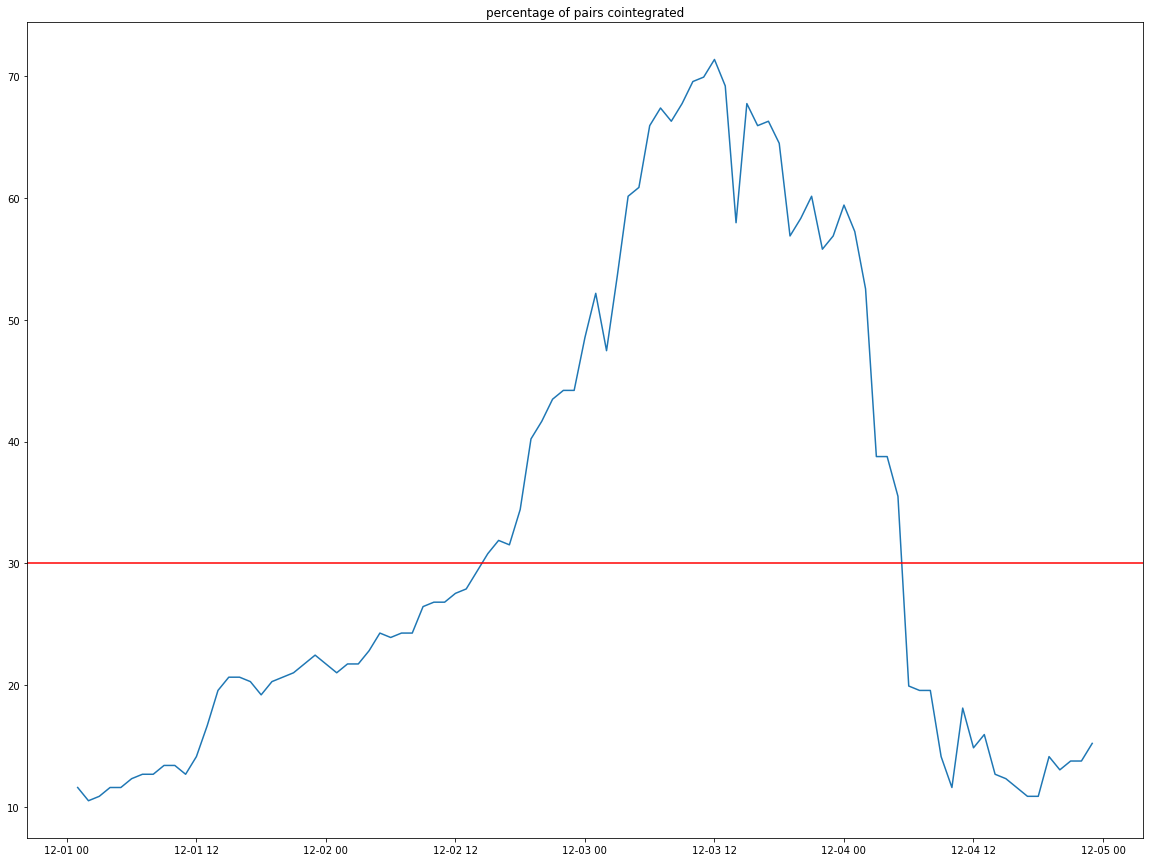

In [67]:
filtered_df = perct_of_coint[perct_of_coint['date'] > '2021-12-01 00:00:00']
filtered_df = filtered_df[filtered_df['date'] < '2021-12-05 00:00:00']
filtered_df.sort_values(['perct_of_coint'], ascending=False)

plt.figure(figsize=(20,15))
plt.title('percentage of pairs cointegrated')
plt.plot(filtered_df['date'], filtered_df['perct_of_coint'])
plt.axhline(y=30, color='red', linestyle='-')
filtered_df

In [36]:
#pairs['all'].to_csv('consecutive_cointegration_1h.csv')

In [69]:
#perct_of_coint.to_csv('perct_of_cointegration_6months.csv')

In [37]:
pairs_pertenciles = pd.DataFrame(pairs['all']['median'].rank(pct=True)).sort_values(['median'], ascending=False)
pairs_pertenciles[pairs_pertenciles['median'] > 0.9]

,median
pair,
1000SHIBUSDT/ADAUSDT,1.000000
LUNAUSDT/ADAUSDT,0.996094
BTCUSDT/LTCUSDT,0.992188
ADAUSDT/LINKUSDT,0.988281
NEARUSDT/RUNEUSDT,0.982422
ADAUSDT/LTCUSDT,0.982422
1000SHIBUSDT/LINKUSDT,0.974609
ADAUSDT/ATOMUSDT,0.974609
NEARUSDT/AVAXUSDT,0.966797


In [38]:
pairs['all'].loc['SANDUSDT/AXSUSDT']

start_date_max        2021-12-02 01:00:00
max                                  53.0
min                                   5.0
mean                            18.866667
median                               14.0
times_cointegrated                    2.0
beta                                  1.0
Name: SANDUSDT/AXSUSDT, dtype: object

In [39]:
pairs['all'].sort_values(['median'], ascending=False)

,start_date_max,max,min,mean,median,times_cointegrated,beta
pair,,,,,,,
1000SHIBUSDT/ADAUSDT,2021-10-08 01:00:00,145.0,5.0,73.875000,77.0,2.0,1.0
LUNAUSDT/ADAUSDT,2022-01-20 07:00:00,131.0,5.0,32.181818,32.0,2.0,1.0
BTCUSDT/LTCUSDT,2021-10-19 07:00:00,133.0,4.0,38.785714,31.5,2.0,1.0
ADAUSDT/LINKUSDT,2022-01-20 07:00:00,131.0,6.0,32.181818,27.0,2.0,1.0
NEARUSDT/RUNEUSDT,2021-10-06 07:00:00,79.0,4.0,28.222222,26.0,2.0,1.0
...,...,...,...,...,...,...,...
1000SHIBUSDT/KNCUSDT,2021-09-08 04:00:00,31.0,4.0,10.363636,6.0,2.0,1.0
MATICUSDT/LINKUSDT,2021-09-06 15:00:00,26.0,4.0,10.058824,6.0,2.0,1.0
RUNEUSDT/LINKUSDT,2021-12-20 07:00:00,21.0,4.0,8.714286,6.0,2.0,1.0


## Rolling percentage of pairs cointegrated

## Z-Score

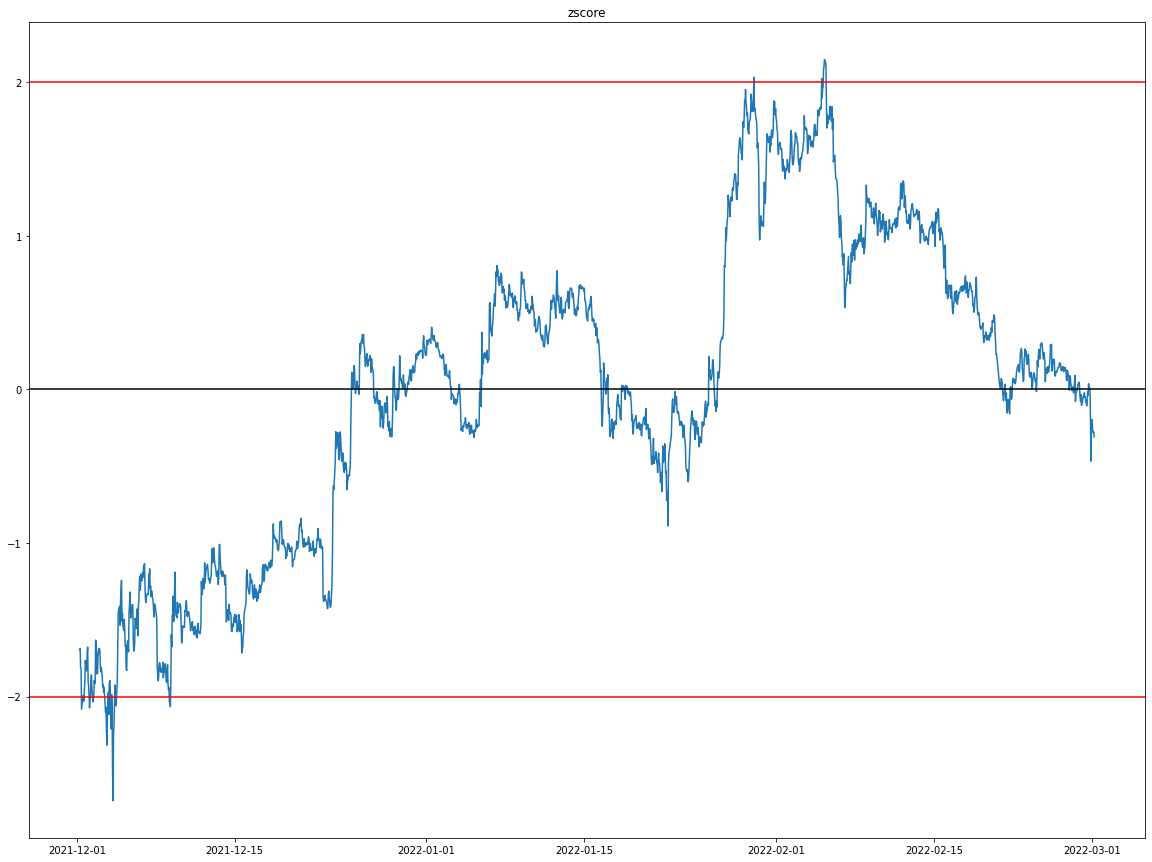

In [14]:
spread = data_A['price'] - data_B['price']
zscore = stats.zscore(spread)
df = pd.DataFrame({'x': data_A['date'], 'y':zscore})
std = df['y'].std()

plt.figure(figsize=(20,15))
plt.title('zscore')
plt.plot(df['x'],df['y'])
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=std*2, color='r', linestyle='-')
plt.axhline(y=-std*2, color='r', linestyle='-')